In [3]:
pip install tensornetwork

  Using cached tensornetwork-0.4.6-py3-none-any.whl (364 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)

[notice] A new release of pip available: 23.1.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

Raw Image info: (256, 256, 4)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


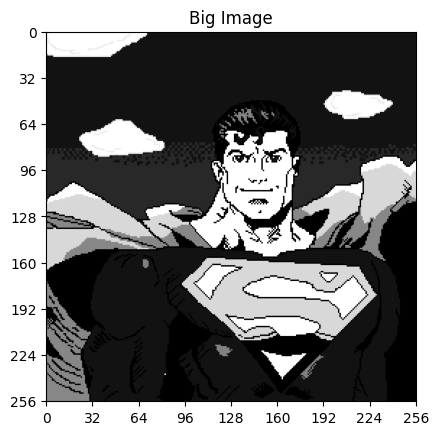

In [15]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('superman.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
          
image = np.array(image)
print('Image shape (numpy array):', image.shape)

# Split the overall image into chunks of size image_crop_size x image_crop_size
imgmat = []

for n in range(int(image_size / image_crop_size)):
    imgmat.append([])
    for m in range(int(image_size / image_crop_size) ):
        lx = int(n * image_crop_size)
        ux = int((n + 1) * image_crop_size)
        ly = int(m * image_crop_size)
        uy = int((m + 1) * image_crop_size)
        imgmat[n].append(image[lx:ux, ly:uy])
        



# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='gray')
plt.show()

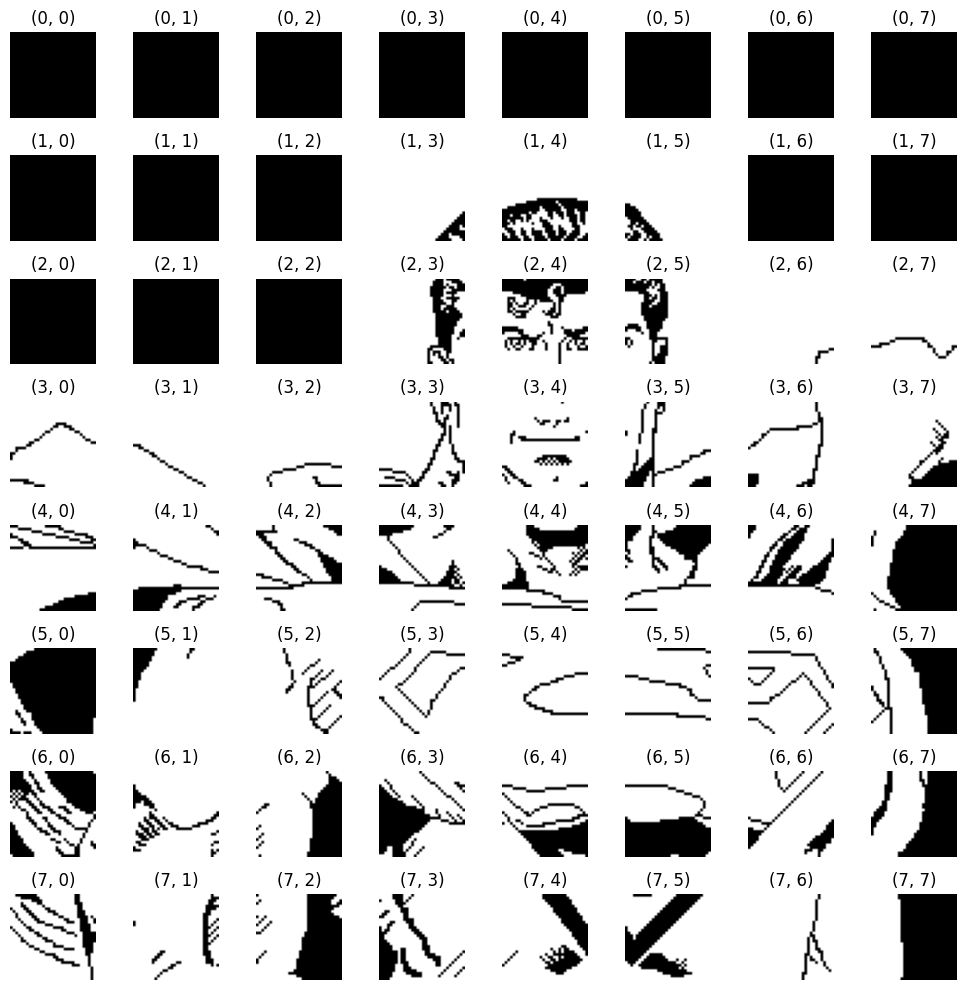

In [16]:
import numpy as np
import qiskit as qk
import tensornetwork as tn
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the filesystem
image_raw = np.array(Image.open('superman.png'))

# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = np.array(image_raw[:, :, 0]) / 255

# Split the overall image into chunks of size image_crop_size x image_crop_size
image_size = 256
image_crop_size = 32
imgmat = []
for n in range(int(image_size / image_crop_size)):
    imgmat.append([])
    for m in range(int(image_size / image_crop_size)):
        lx = int(n * image_crop_size)
        ux = int((n + 1) * image_crop_size)
        ly = int(m * image_crop_size)
        uy = int((m + 1) * image_crop_size)
        imgmat[n].append(image[lx:ux, ly:uy])

# Define tensor network encoding function
def tensor_network_encode(img_data):
    image_norm = tn.Node(img_data)
    return image_norm

# Create the circuit for horizontal and vertical scans
horiz_scan = []
vert_scan = []
threshold = lambda amp: (amp > 1e-3 or amp < -1e-3)
backend = qk.Aer.get_backend('statevector_simulator')
total_qb = 10  # Total number of qubits in the circuit
D2n_1 = np.eye(2**total_qb)

for x in range(int(image_size / image_crop_size)):
    horiz_scan.append([])
    vert_scan.append([])
    for y in range(int(image_size / image_crop_size)):
        image_norm_h = tensor_network_encode(imgmat[x][y])
        image_norm_v = tensor_network_encode(np.transpose(imgmat[x][y]))
        if image_norm_h.tensor.sum() != 0 and image_norm_v.tensor.sum() != 0:
            # Normalize image data
            norm_h = image_norm_h.tensor / np.linalg.norm(image_norm_h.tensor)
            norm_v = image_norm_v.tensor / np.linalg.norm(image_norm_v.tensor)

            qc_h = qk.QuantumCircuit(total_qb)
            qc_h.initialize(norm_h.flatten(), range(total_qb))
            qc_h.h(0)
            qc_h.unitary(D2n_1, range(total_qb))
            qc_h.h(0)

            qc_v = qk.QuantumCircuit(total_qb)
            qc_v.initialize(norm_v.flatten(), range(total_qb))
            qc_v.h(0)
            qc_v.unitary(D2n_1, range(total_qb))
            qc_v.h(0)

            # Simulate the quantum circuit
            job_h = qk.execute(qc_h, backend)
            result_h = job_h.result()
            sv_h = result_h.get_statevector()

            job_v = qk.execute(qc_v, backend)
            result_v = job_v.result()
            sv_v = result_v.get_statevector()

            # Obtain the edge scans
            edge_scan_h = np.abs(np.array([1 if threshold(sv_h[i].real) else 0 for i in range(2**total_qb)])).reshape(image_crop_size, image_crop_size)
            edge_scan_v = np.abs(np.array([1 if threshold(sv_v[i].real) else 0 for i in range(2**total_qb)])).reshape(image_crop_size, image_crop_size)

            horiz_scan[x].append(edge_scan_h)
            vert_scan[x].append(edge_scan_v)

# Plot the horizontal and vertical edge scans
fig, axes = plt.subplots(len(horiz_scan), len(horiz_scan[0]), figsize=(10, 10))
for i in range(len(horiz_scan)):
    for j in range(len(horiz_scan[i])):
        axes[i, j].imshow(horiz_scan[i][j], cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'({i}, {j})')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import qiskit as qk
import tensornetwork as tn
from PIL import Image
import matplotlib.pyplot as plt

# Load the image from the filesystem
image_raw = np.array(Image.open('superman.png'))

# Convert the RGB component of the image to a B&W image, as a numpy (uint8) array
image = np.array(image_raw[:, :, 0]) / 255

# Split the overall image into chunks of size image_crop_size x image_crop_size
image_size = 256
image_crop_size = 32
imgmat = []
for n in range(int(image_size / image_crop_size)):
    imgmat.append([])
    for m in range(int(image_size / image_crop_size)):
        lx = int(n * image_crop_size)
        ux = int((n + 1) * image_crop_size)
        ly = int(m * image_crop_size)
        uy = int((m + 1) * image_crop_size)
        imgmat[n].append(image[lx:ux, ly:uy])

# Define tensor network encoding function
def tensor_network_encode(img_data):
    image_norm = tn.Node(img_data)
    return image_norm

# Create the circuit for horizontal and vertical scans
horiz_scan = []
vert_scan = []
threshold = lambda amp: (amp > 1e-3 or amp < -1e-3)
backend = qk.Aer.get_backend('statevector_simulator')
total_qb = 10  # Total number of qubits in the circuit
D2n_1 = np.eye(2**total_qb)

for x in range(int(image_size / image_crop_size)):
    horiz_scan.append([])
    vert_scan.append([])
    for y in range(int(image_size / image_crop_size)):
        image_norm_h = tensor_network_encode(imgmat[x][y])
        image_norm_v = tensor_network_encode(np.transpose(imgmat[x][y]))
        if image_norm_h.tensor.sum() != 0 and image_norm_v.tensor.sum() != 0:
            # Normalize image data
            norm_h = image_norm_h.tensor / np.linalg.norm(image_norm_h.tensor)
            norm_v = image_norm_v.tensor / np.linalg.norm(image_norm_v.tensor)

            qc_h = qk.QuantumCircuit(total_qb)
            qc_h.initialize(norm_h.flatten(), range(total_qb))
            qc_h.h(0)
            qc_h.unitary(D2n_1, range(total_qb))
            qc_h.h(0)

            qc_v = qk.QuantumCircuit(total_qb)
            qc_v.initialize(norm_v.flatten(), range(total_qb))
            qc_v.h(0)
            qc_v.unitary(D2n_1, range(total_qb))
            qc_v.h(0)

            # Simulate the quantum circuit
            job_h = qk.execute(qc_h, backend)
            result_h = job_h.result()
            sv_h = result_h.get_statevector()

            job_v = qk.execute(qc_v, backend)
            result_v = job_v.result()
            sv_v = result_v.get_statevector()

            # Obtain the edge scans
            edge_scan_h = np.abs(np.array([1 if threshold(sv_h[i].real) else 0 for i in range(2**total_qb)])).reshape(image_crop_size, image_crop_size)
            edge_scan_v = np.abs(np.array([1 if threshold(sv_v[i].real) else 0 for i in range(2**total_qb)])).reshape(image_crop_size, image_crop_size)

            horiz_scan[x].append(edge_scan_h)
            vert_scan[x].append(edge_scan_v)

# Combine the horizontal and vertical scans for each chunk
edge_scan_sim = []
for hrow, vrow in zip(horiz_scan, vert_scan):
    edge_scan_sim.append([])
    for h,v in zip(hrow, vrow):
        edge_scan_sim[-1].append(h)

# Recombine the chunks into a single image
edge_rows = [np.hstack(row) for row in edge_scan_sim]
edges = np.vstack(edge_rows)

# Plot the resulting image
plt.title('Combined Edge Scans')
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()